In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits
from data_process import weight_nan_mean, load_calculation_data, calculate_jackknife_variance
from sklearn.neighbors import KDTree

In [2]:
Nside_jack = 4
r_p, dat = load_calculation_data('../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data('../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_8_tree.npy')

with open('label.bin', 'rb') as f:
    pix_q = np.load(f)
    pix_rall = np.load(f)

In [3]:
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
# c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# pix_q = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
print('finish loading quasar catalogue')

random_sample = np.load('../catalogue/random_quasar_lss_all.npy')
# c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)
# assert (random_sample['w']==1).all()
# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# pix_rall = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


In [4]:
bins = np.linspace(0.8, 2.2, 4)            # the z cut applied to quasar lss all
bins = np.percentile(quasar_cata['z'], [0, 100/3, 200/3, 100])
result = np.digitize(quasar_cata['z'], bins)
result_r = np.digitize(random_sample['z'], bins)

In [5]:
for bin in range(1, 4):
    suffix = f'z{bin}_2'

    index = result == bin
    index_r = result_r == bin

    value = dat[0,index]
    weight = dat[1,index]
    pix = pix_q[index]
    print(len(pix))
    value_r = dat_r[0,index_r]
    weight_r = dat_r[1,index_r]
    pix_r = pix_rall[index_r]
    sampler_sub  = calculate_jackknife_variance(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True)
    np.savetxt(f'./results/quasar_lss_all_{suffix}_cmb_smoothed_6', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])


114569
114569
114569


In [10]:
zs = (bins[1:] + bins[:-1])/2

In [11]:
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100

In [37]:
(cosmos.comoving_distance(z=zs).to(u.Mpc).value*h)

array([2390.44136067, 3047.77082097, 3549.7711507 ])

In [12]:
savefig = False

## quasar sample

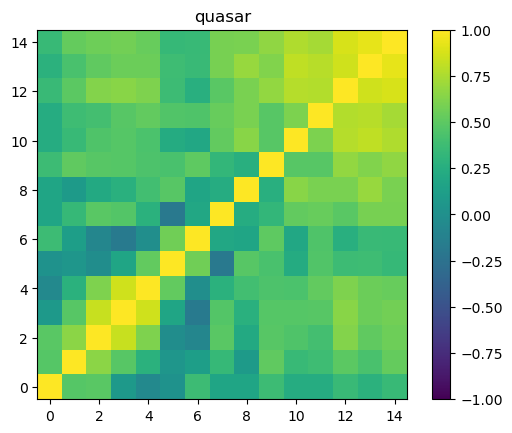

In [22]:
sampler_q = calculate_jackknife_variance(value, weight, pix, norm_cov=True)

plt.imshow(sampler_q['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

## random sample

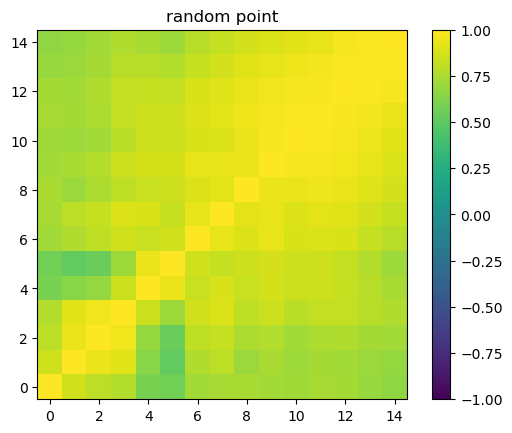

In [15]:
#sampler_r = jackknife_sampler(value_r, weight_r, pix_r, norm_cov=True, Npro=60)
sampler_r = calculate_jackknife_variance(value_r, weight_r, pix_r, norm_cov=True)

plt.imshow(sampler_r['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_r')
plt.show()

## quasar - random

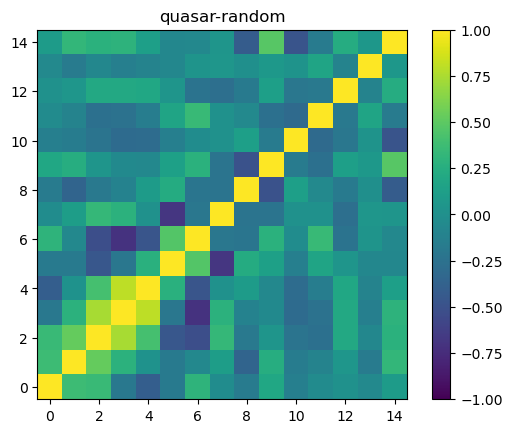

In [20]:
sampler_sub  = calculate_jackknife_variance(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True)
plt.imshow(sampler_sub['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

## signal

In [21]:
np.savetxt(f'./results/quasar_lss_all_{suffix}_cmb_lcut_n_2048', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

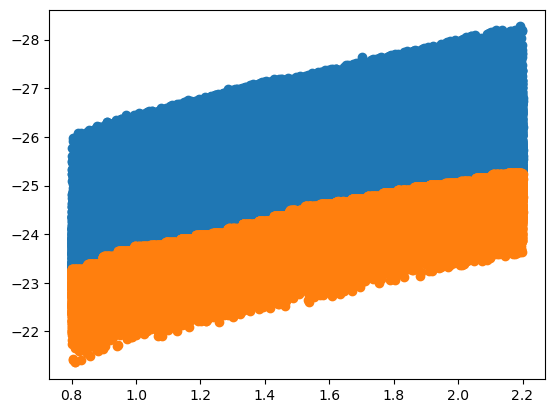

In [6]:
plt.scatter(quasar_cata['z'][index_h], M_I[index_h])
plt.scatter(quasar_cata['z'][index_l], M_I[index_l])
plt.gca().invert_yaxis()